# Deep Graph Library

<a href="https://colab.research.google.com/github/joerg84/Graph_Powered_ML_Workshop/blob/master/DGL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, setting up our environment.

In [1]:
%%capture
!git clone https://github.com/joerg84/Graph_Powered_ML_Workshop.git
!rsync -av Graph_Powered_ML_Workshop/ ./ --exclude=.git
!pip3 install dgl
!pip3 install numpy
!pip3 install torch
!pip3 install networkx
!pip3 install matplotlib

In [ ]:
%matplotlib inline

In [2]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import dgl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Remember the Karate Club ![karate](https://github.com/joerg84/Graph_Powered_ML_Workshop/blob/master/img/karate_club.png?raw=1)

In [3]:
def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

In [4]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


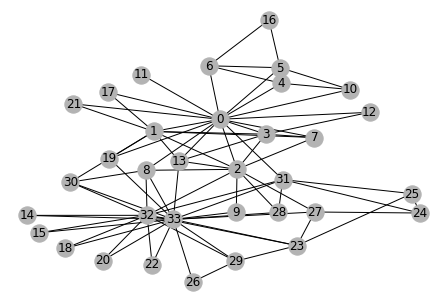

In [5]:
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [6]:
# In DGL, you can add features for all nodes at once, using a feature tensor that
# batches node features along the first dimension. The code below adds the learnable
# embeddings for all nodes:

embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([-1.1548, -1.7777,  0.5151, -0.4116, -0.4845], grad_fn=<SelectBackward>)
tensor([[-1.0107, -0.0930, -0.8748, -1.0058,  0.4144],
        [-0.3515, -0.4143, -0.5736, -1.7288, -0.7816]],
       grad_fn=<IndexBackward>)


# Create GCN

In [7]:
 class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)

Label the instructor and president

In [8]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [9]:
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.5311
Epoch 1 | Loss: 0.5067
Epoch 2 | Loss: 0.4821
Epoch 3 | Loss: 0.4563
Epoch 4 | Loss: 0.4304
Epoch 5 | Loss: 0.4012
Epoch 6 | Loss: 0.3705
Epoch 7 | Loss: 0.3406
Epoch 8 | Loss: 0.3113
Epoch 9 | Loss: 0.2833
Epoch 10 | Loss: 0.2570
Epoch 11 | Loss: 0.2321
Epoch 12 | Loss: 0.2083
Epoch 13 | Loss: 0.1853
Epoch 14 | Loss: 0.1634
Epoch 15 | Loss: 0.1433
Epoch 16 | Loss: 0.1251
Epoch 17 | Loss: 0.1086
Epoch 18 | Loss: 0.0939
Epoch 19 | Loss: 0.0809
Epoch 20 | Loss: 0.0695
Epoch 21 | Loss: 0.0595
Epoch 22 | Loss: 0.0508
Epoch 23 | Loss: 0.0433
Epoch 24 | Loss: 0.0370
Epoch 25 | Loss: 0.0316
Epoch 26 | Loss: 0.0271
Epoch 27 | Loss: 0.0232
Epoch 28 | Loss: 0.0200
Epoch 29 | Loss: 0.0173
Epoch 30 | Loss: 0.0150
Epoch 31 | Loss: 0.0131
Epoch 32 | Loss: 0.0115
Epoch 33 | Loss: 0.0101
Epoch 34 | Loss: 0.0090
Epoch 35 | Loss: 0.0080
Epoch 36 | Loss: 0.0071
Epoch 37 | Loss: 0.0064
Epoch 38 | Loss: 0.0058
Epoch 39 | Loss: 0.0052
Epoch 40 | Loss: 0.0048
Epoch 41 | Loss: 0.0044
Ep

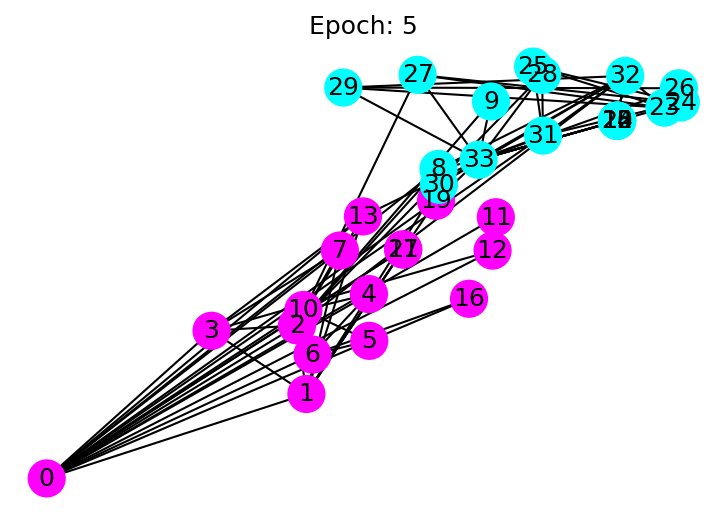

In [10]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(5) # Iterate to see different epochs
plt.show()
plt.close()

Next task: Try to implement graph classification (https://docs.dgl.ai/tutorials/basics/4_batch.html)

 ![Graph Types](https://github.com/joerg84/Graph_Powered_ML_Workshop/blob/master/img/graph_types.png?raw=1)

# Exercise 2-2: Graph Learning Tasks
Pick one of the following Graph Learning Tasks from the DGL Guide and
create a python tutorial (preferably as jupyter notebook) for that example.
Feel free to choose another dataset (http://kaggle.com is a good starting
point).
1. Node Classification/Regression
2. Edge Classification/Regression
3. Link Prediction
4. Graph Classification

# Node Classification/Regression
One of the most popular and widely adopted tasks for graph neural networks is node classification, where each node in the training/validation/test set is assigned a ground truth category from a set of predefined categories. Node regression is similar, where each node in the training/validation/test set is assigned a ground truth number.

## Overview
To classify nodes, graph neural network performs message passing discussed in Chapter 2: Message Passing to utilize the node’s own features, but also its neighboring node and edge features. Message passing can be repeated multiple rounds to incorporate information from larger range of neighborhood.

## Writing neural network model
DGL provides a few built-in graph convolution modules that can perform one round of message passing. In this guide, we choose `dgl.nn.pytorch.SAGEConv` (also available in MXNet and Tensorflow), the graph convolution module for GraphSAGE.

Usually for deep learning models on graphs we need a multi-layer graph neural network, where we do multiple rounds of message passing. This can be achieved by stacking graph convolution modules as follows.


In [18]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

Note that you can use the model above for not only node classification,
but also obtaining hidden node representations for other downstream
tasks such as
`guide-training-edge-classification`,
`guide-training-link-prediction`, or
`guide-training-graph-classification`.

For a complete list of built-in graph convolution modules, please refer
to `apinn`.

For more details in how DGL
neural network modules work and how to write a custom neural network
module with message passing please refer to the example in `guide-nn`.


## Training loop

Training on the full graph simply involves a forward propagation of the
model defined above, and computing the loss by comparing the prediction
against ground truth labels on the training nodes.

This section uses a DGL built-in dataset
`dgl.data.CiteseerGraphDataset` to
show a training loop. The node features
and labels are stored on its graph instance, and the
training-validation-test split are also stored on the graph as boolean
masks. This is similar to what you have seen in `guide-data-pipeline`.


In [13]:
import dgl

dataset = dgl.data.CiteseerGraphDataset()
graph = dataset[0]

Extracting file to /root/.dgl/citeseer


/usr/local/lib/python3.6/dist-packages/dgl/data/citation_graph.py:258: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [19]:
node_features = graph.ndata['feat']
node_labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

The following is an example of evaluating your model by accuracy.


In [21]:
  def evaluate(model, graph, features, labels, mask):
      model.eval()
      with torch.no_grad():
          logits = model(graph, features)
          logits = logits[mask]
          labels = labels[mask]
          _, indices = torch.max(logits, dim=1)
          correct = torch.sum(indices == labels)
          return correct.item() * 1.0 / len(labels)

You can then write our training loop as follows.


In [22]:
    model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
    opt = torch.optim.Adam(model.parameters())
    
    for epoch in range(10):
        model.train()
        # forward propagation by using all nodes
        logits = model(graph, node_features)
        # compute loss
        loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
        # compute validation accuracy
        acc = evaluate(model, graph, node_features, node_labels, valid_mask)
        # backward propagation
        opt.zero_grad()
        loss.backward()
        opt.step()
        print(loss.item())

1.7968807220458984
1.782396912574768
1.768399715423584
1.7538681030273438
1.7386645078659058
1.7228853702545166
1.7065966129302979
1.6898456811904907
1.6727267503738403
1.65500807762146


[GraphSAGE](https://github.com/dmlc/dgl/blob/master/examples/pytorch/graphsage/train_full.py)
provides an end-to-end homogeneous graph node classification example.
You could see the corresponding model implementation is in the
``GraphSAGE`` class in the example with adjustable number of layers,
dropout probabilities, and customizable aggregation functions and
nonlinearities.

# Heterogeneous graph

If your graph is heterogeneous, you may want to gather message from
neighbors along all edge types. You can use the module `dgl.nn.pytorch.HeteroGraphConv` (also available in MXNet and Tensorflow)
to perform message passing
on all edge types, then combining different graph convolution modules
for each edge type.

The following code will define a heterogeneous graph convolution module
that first performs a separate graph convolution on each edge type, then
sums the message aggregations on each edge type as the final result for
all node types.


In [23]:
    # Define a Heterograph Conv model
    import dgl.nn as dglnn
    
    class RGCN(nn.Module):
        def __init__(self, in_feats, hid_feats, out_feats, rel_names):
            super().__init__()
            
            self.conv1 = dglnn.HeteroGraphConv({
                rel: dglnn.GraphConv(in_feats, hid_feats)
                for rel in rel_names}, aggregate='sum')
            self.conv2 = dglnn.HeteroGraphConv({
                rel: dglnn.GraphConv(hid_feats, out_feats)
                for rel in rel_names}, aggregate='sum')
      
        def forward(self, graph, inputs):
            # inputs are features of nodes
            h = self.conv1(graph, inputs)
            h = {k: F.relu(v) for k, v in h.items()}
            h = self.conv2(graph, h)
            return h

``dgl.nn.HeteroGraphConv`` takes in a dictionary of node types and node
feature tensors as input, and returns another dictionary of node types
and node features.

So given that we have the user and item features in the
`heterogeneous graph example <guide-training-heterogeneous-graph-example>`.


In [27]:
n_users = 1000
n_items = 500
n_follows = 3000
n_clicks = 5000
n_dislikes = 500
n_hetero_features = 10
n_user_classes = 5
n_max_clicks = 10

follow_src = np.random.randint(0, n_users, n_follows)
follow_dst = np.random.randint(0, n_users, n_follows)
click_src = np.random.randint(0, n_users, n_clicks)
click_dst = np.random.randint(0, n_items, n_clicks)
dislike_src = np.random.randint(0, n_users, n_dislikes)
dislike_dst = np.random.randint(0, n_items, n_dislikes)

hetero_graph = dgl.heterograph({
    ('user', 'follow', 'user'): (follow_src, follow_dst),
    ('user', 'followed-by', 'user'): (follow_dst, follow_src),
    ('user', 'click', 'item'): (click_src, click_dst),
    ('item', 'clicked-by', 'user'): (click_dst, click_src),
    ('user', 'dislike', 'item'): (dislike_src, dislike_dst),
    ('item', 'disliked-by', 'user'): (dislike_dst, dislike_src)})

hetero_graph.nodes['user'].data['feature'] = torch.randn(n_users, n_hetero_features)
hetero_graph.nodes['item'].data['feature'] = torch.randn(n_items, n_hetero_features)
hetero_graph.nodes['user'].data['label'] = torch.randint(0, n_user_classes, (n_users,))
hetero_graph.edges['click'].data['label'] = torch.randint(1, n_max_clicks, (n_clicks,)).float()
# randomly generate training masks on user nodes and click edges
hetero_graph.nodes['user'].data['train_mask'] = torch.zeros(n_users, dtype=torch.bool).bernoulli(0.6)
hetero_graph.edges['click'].data['train_mask'] = torch.zeros(n_clicks, dtype=torch.bool).bernoulli(0.6)


model = RGCN(n_hetero_features, 20, n_user_classes, hetero_graph.etypes)
user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
labels = hetero_graph.nodes['user'].data['label']
train_mask = hetero_graph.nodes['user'].data['train_mask']

One can simply perform a forward propagation as follows:



In [28]:
node_features = {'user': user_feats, 'item': item_feats}
h_dict = model(hetero_graph, {'user': user_feats, 'item': item_feats})
h_user = h_dict['user']
h_item = h_dict['item']

Training loop is the same as the one for homogeneous graph, except that
now you have a dictionary of node representations from which you compute
the predictions. For instance, if you are only predicting the ``user``
nodes, you can just extract the ``user`` node embeddings from the
returned dictionary:


In [30]:
opt = torch.optim.Adam(model.parameters())
    
for epoch in range(5):
    model.train()
    # forward propagation by using all nodes and extracting the user embeddings
    logits = model(hetero_graph, node_features)['user']
    # compute loss
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    # Compute validation accuracy.  Omitted in this example.
    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

1.8600527048110962
1.8458691835403442
1.8325189352035522
1.8200165033340454
1.8083372116088867
